In [1]:
import numpy as np
import glob
import os
%pylab inline --no-import-all
# plt.rc('font', family='serif', serif='Times', size=15)
plt.rc('text', usetex=True)
plt.rc('xtick', labelsize=20)
plt.rc('xtick.major', size=10)
plt.rc('ytick.major', size=10)
plt.rc('ytick', labelsize=20)
plt.rc('axes', labelsize=20)
plt.rc('figure', titlesize=25)
plt.rcParams['image.origin'] = 'lower'
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['axes.linewidth'] = 2.
from astropy.io import fits

import logging as log
from crispy.tools.initLogger import getLogger
log = getLogger('main')
from crispy.tools.image import Image
from astropy.io import fits
cmap = 'inferno'  # 'gray_r'

Populating the interactive namespace from numpy and matplotlib


# Load data

In [2]:
os.chdir('/Users/mrizzo/IFS/crispy/crispy/HCIFS/')
from params import Params
par = Params()

fname = par.wavecalDir+'channel05_flat(1).fits'
data = fits.getdata(fname)

# Show histogram

(-10, 50)

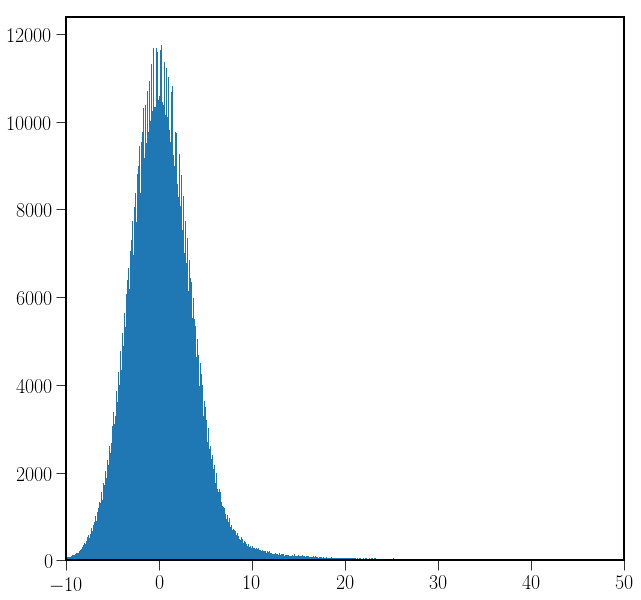

In [12]:
plt.figure(figsize=(10,10))
plt.hist(np.reshape(data,-1),bins='auto')
plt.xlim([-10,50])

# Extract sources with photutils

In [33]:
from photutils import find_peaks
from photutils import DAOStarFinder
from astropy.table import Table
from astropy.stats import sigma_clipped_stats
mean_val, median_val, std_val = sigma_clipped_stats(data, sigma=2.,
                                                    iters=None)
print(mean_val, median_val, std_val)
peaks_tbl = find_peaks(data, threshold=4*std_val, box_size=15)
peaks_tbl['peak_value'].info.format = '%.8g'  # for consistent table output

# daofind = DAOStarFinder(fwhm=2.0, threshold=5.*std_val)
data -= median_val

# sources = daofind(data)    
# for col in sources.colnames:    
#     sources[col].info.format = '%.8g'  # for consistent table output

stars_tbl = Table()
stars_tbl['x'] = peaks_tbl['x_peak']
stars_tbl['y'] = peaks_tbl['y_peak']

from astropy.nddata import NDData
nddata = NDData(data=data)
from photutils.psf import extract_stars
stars = extract_stars(nddata, stars_tbl, size=12)

0.0024270879936774546 0.0 2.2658249118157188


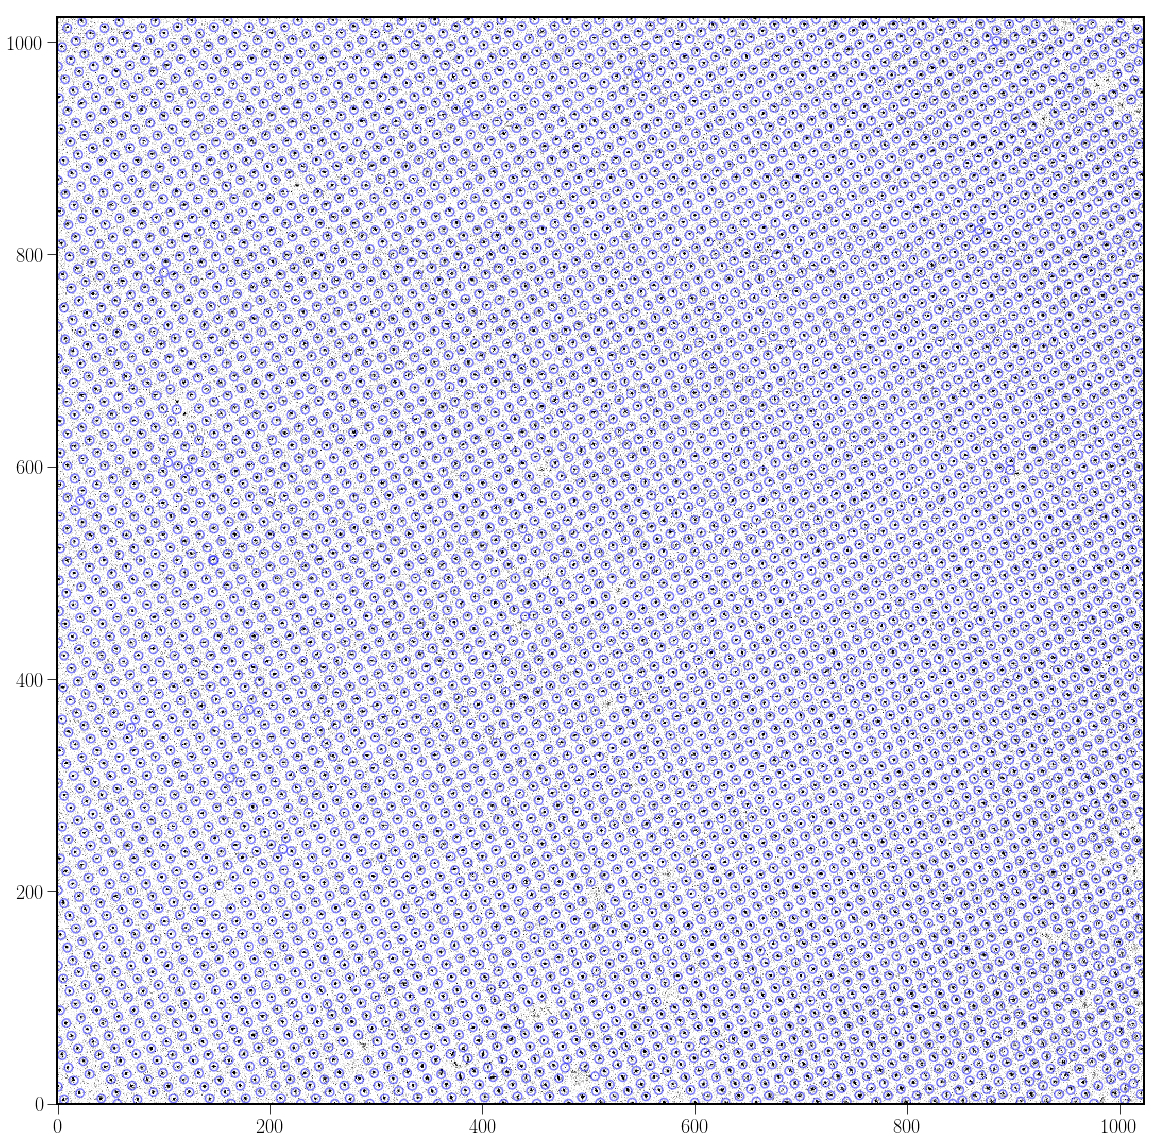

In [37]:
import matplotlib.pyplot as plt
from astropy.visualization import SqrtStretch
from astropy.visualization.mpl_normalize import ImageNormalize
from photutils import CircularAperture
positions = (peaks_tbl['x_peak'], peaks_tbl['y_peak'])
apertures = CircularAperture(positions, r=4.)
norm = ImageNormalize(stretch=SqrtStretch())
plt.figure(figsize=(20,20))
plt.imshow(data, cmap='gray_r', origin='lower', vmin=0,vmax=5*std_val)
apertures.plot(color='blue', lw=1.5, alpha=0.5)

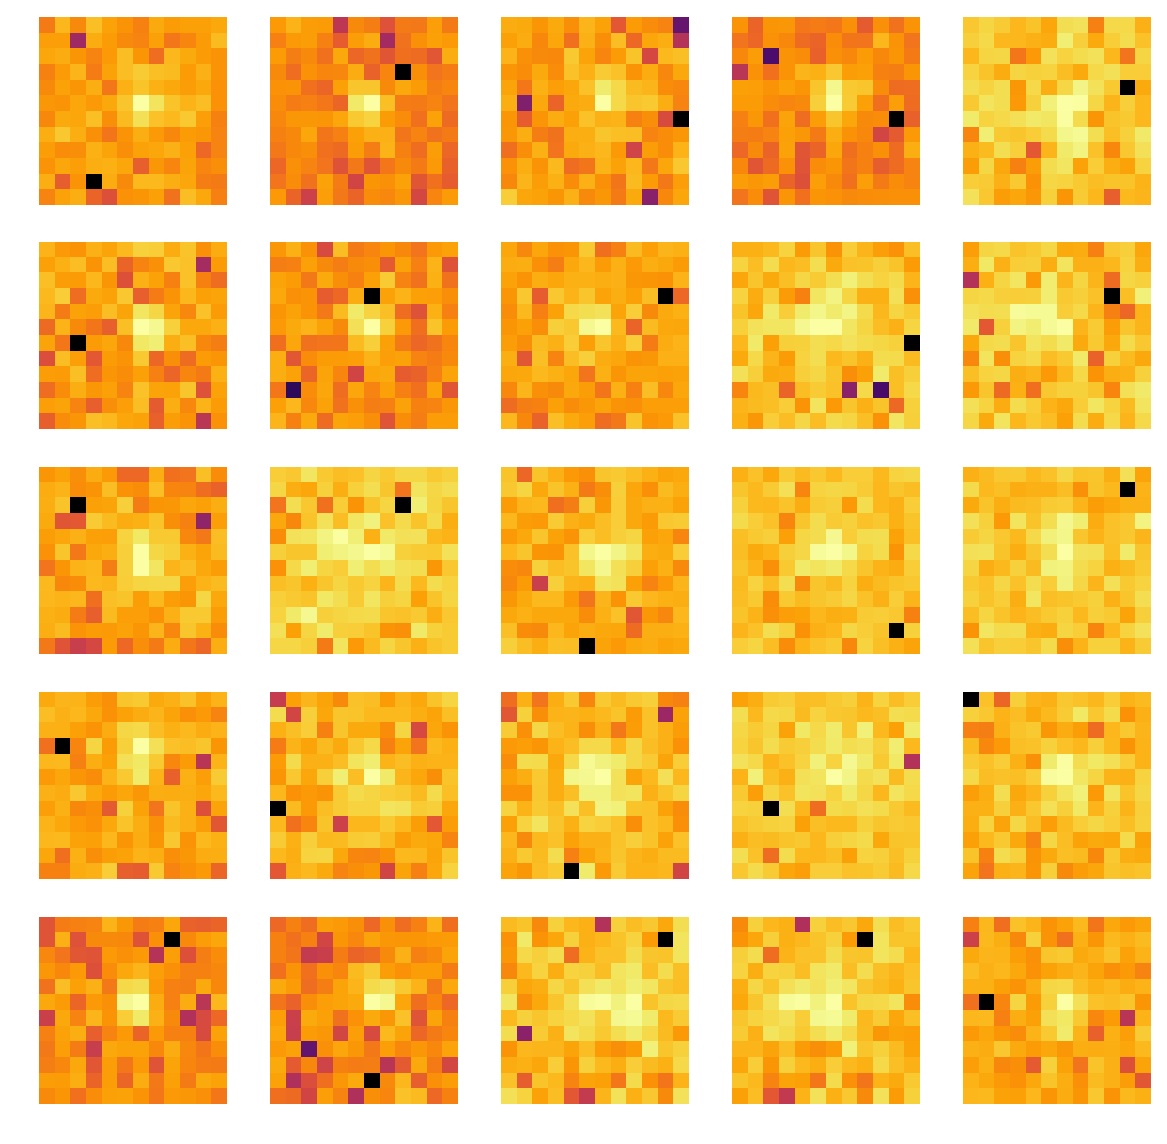

In [15]:
import matplotlib.pyplot as plt
from astropy.visualization import simple_norm
nrows = 5
ncols = 5
fig, ax = plt.subplots(nrows=nrows, ncols=ncols, figsize=(20, 20),
                       squeeze=True)
ax = ax.ravel()
for i in range(nrows*ncols):
    norm = simple_norm(stars[i], 'log', percent=99.9)
    ax[i].imshow(stars[i], norm=norm, origin='lower', cmap=cmap)
    ax[i].axis('off')

In [16]:
from photutils import EPSFBuilder
epsf_builder = EPSFBuilder(oversampling=4, maxiters=3,
                           progress_bar=True)
epsf, fitted_stars = epsf_builder(stars)


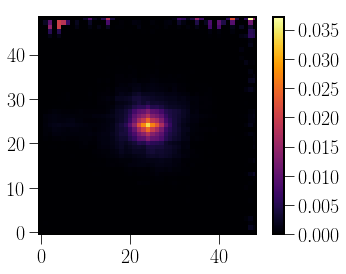

In [18]:
import matplotlib.pyplot as plt
from astropy.visualization import simple_norm
norm = simple_norm(epsf.data, 'log', percent=99.)
epsf.data[epsf.data<0.0]=0.0
plt.imshow(epsf.data, origin='lower', cmap=cmap)
plt.colorbar()

# Try with crispy wavecal centroids

In [50]:
lamsol = np.loadtxt(par.wavecalDir + "lamsol.dat")[:, 0]
allcoef = np.loadtxt(par.wavecalDir + "lamsol.dat")[:, 1:]
log.info(lamsol)
log.info(allcoef[4])

main - INFO - [550.  577.  600.  620.  632.8 640.  650.  670.  694.3 720.  740. ]
main - INFO - [ 5.28699303e+02  1.21103371e+01 -2.66977922e-02  5.18853952e-05
 -5.82616628e+00  7.66217760e-03 -3.77157241e-05 -2.04574213e-02
  4.59146323e-05 -1.89136158e-05  5.13458898e+02  6.02230589e+00
  6.97245896e-05  1.67325729e-06  1.19043451e+01 -5.80152814e-05
  6.60126760e-07  1.99188871e-04  1.00529545e-06  2.49811677e-06]


In [86]:
from crispy.tools.locate_psflets import PSFLets,transform

xindx = np.arange(-par.nlens // 2, par.nlens // 2)
xindx, yindx = np.meshgrid(xindx, xindx)

psftool = PSFLets()
psftool.geninterparray(lamsol, allcoef)
x,y = psftool.return_locations(lamsol[4], allcoef, xindx, yindx)
x,y = transform(xindx, yindx, 3, allcoef[4])
print(x[par.nlens//2,par.nlens//2+1])
print(y[par.nlens//2,par.nlens//2+1])

[[ 1.76620729e+03 -8.67300272e+01  1.22766728e+00  4.22321507e-02
  -2.80159321e+01 -5.09876623e-01 -1.39630291e-02  1.24336373e+00
   4.18636119e-02  5.39421698e-02  1.94394462e+03  4.63670528e+01
  -1.42508255e+00 -3.98257092e-03 -8.12043934e+01  1.95790753e-01
   2.88563145e-03 -5.53403887e-01 -1.53222338e-01  4.11222778e-02]
 [-8.65271781e+02  4.44795150e+01 -5.87285902e-01 -1.93965015e-02
   1.16486049e+01  2.35051585e-01  5.89833233e-03 -5.94804180e-01
  -1.96758862e-02 -2.54500156e-02 -6.49350253e+02 -1.87035902e+01
   6.56977294e-01  1.85239544e-03  4.31982411e+01 -9.10583375e-02
  -1.45174796e-03  2.52409629e-01  7.08166887e-02 -1.91906068e-02]
 [ 1.63228426e+02 -6.65921308e+00  9.14286246e-02  2.97181935e-03
  -2.00959247e+00 -3.54678280e-02 -8.25827808e-04  9.31314680e-02
   3.08239521e-03  3.99843489e-03  9.83046854e+01  2.89071804e+00
  -1.00937296e-01 -2.87160176e-04 -6.67881733e+00  1.41156445e-02
   2.40945548e-04 -3.83387285e-02 -1.09089154e-02  2.98399700e-03]
 [-9.11

/Users/mrizzo/anaconda2/envs/py36/lib/python3.6/site-packages/crispy-0.9-py3.6.egg/crispy/tools/locate_psflets.py:135: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  coef = np.linalg.lstsq(xarr, allcoef[:, i])[0]


In [87]:
from crispy.tools.wavecal import do_inspection
do_inspection(par, data, x,y, lamsol[4])